In [1]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import torchaudio
import torchvision
import random
import librosa

In [2]:
sns.set_theme()
torch.__version__, torchaudio.__version__, torchvision.__version__

('2.3.1', '2.3.1', '0.18.1')

In [3]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )

In [4]:
DATA_FOLDER = Path("../data")
CAPUCHIN_CLIPS_FOLDER = DATA_FOLDER / "Parsed_Capuchinbird_Clips"
NOT_CAPUCHIN_CLIPS_FOLDER = DATA_FOLDER / "Parsed_Not_Capuchinbird_Clips"
CAPUCHIN_CLIPS_FOLDER.exists(), NOT_CAPUCHIN_CLIPS_FOLDER.exists()

(True, True)

In [5]:
sample_capuchin_clip_path = random.choice(list(CAPUCHIN_CLIPS_FOLDER.iterdir()))
sample_not_capuchin_clip_path = random.choice(list(NOT_CAPUCHIN_CLIPS_FOLDER.iterdir()))
sample_capuchin_clip_metadata = torchaudio.info(sample_capuchin_clip_path)
sample_not_capuchin_clip_metadata = torchaudio.info(sample_not_capuchin_clip_path)
print(f"capuchin_clip: {sample_capuchin_clip_metadata}")
print(f"not_capuchin_clip: {sample_not_capuchin_clip_metadata}")

capuchin_clip: AudioMetaData(sample_rate=48000, num_frames=192000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
not_capuchin_clip: AudioMetaData(sample_rate=44100, num_frames=134240, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [6]:
NUM_FRAMES = 48000
SAMPLE_RATE = 16000


def preprocess_waveform(clip_path: Path) -> torch.Tensor:
    clip_waveform, clip_sample_rate = torchaudio.load(clip_path)
    # only get the first channel
    clip_waveform = clip_waveform[0, :].unsqueeze(0)
    # resample the clip
    resampled_clip = torchaudio.functional.resample(
        clip_waveform, clip_sample_rate, SAMPLE_RATE
    )
    print(resampled_clip.shape)
    resampled_clip = resampled_clip[:, :NUM_FRAMES]
    # pad the clip if necessary
    if resampled_clip.shape[1] < NUM_FRAMES:
        zero_padding = torch.zeros((1, NUM_FRAMES - resampled_clip.shape[1]))
        resampled_clip = torch.concat((resampled_clip, zero_padding), dim=1)
    return resampled_clip

In [7]:
preprocessed_clip = preprocess_waveform(sample_capuchin_clip_path)
preprocessed_clip.shape

torch.Size([1, 64000])


torch.Size([1, 48000])

In [8]:
n_ffts = [32, 64, 128, 256, 512, 2048]
hop_length = 128

specs = []
for n_fft in n_ffts:
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(preprocessed_clip)
    specs.append(spec)

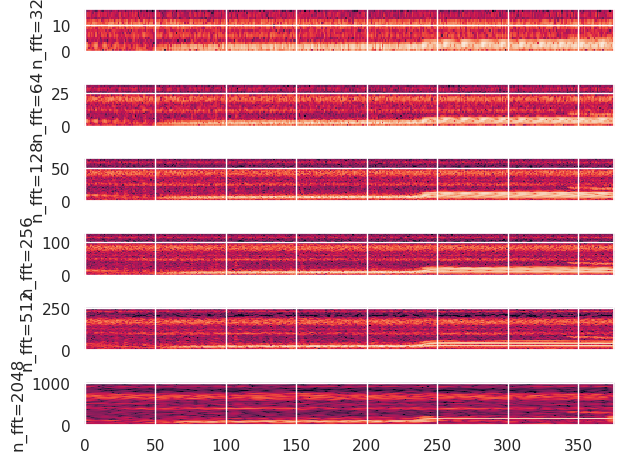

In [9]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

torch.Size([1, 48704])


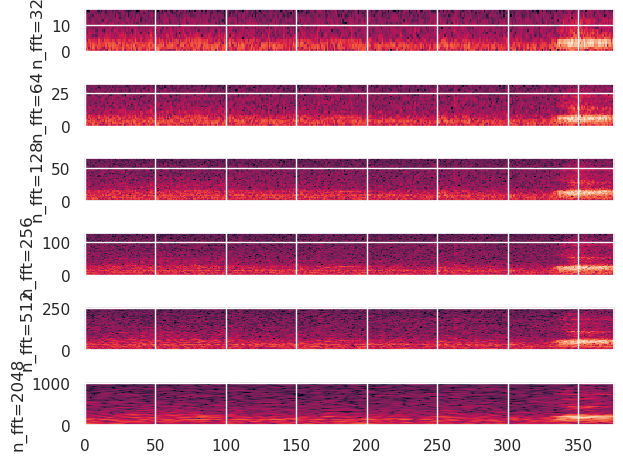

In [10]:
preprocessed_clip = preprocess_waveform(sample_not_capuchin_clip_path)
n_ffts = [32, 64, 128, 256, 512, 2048]
hop_length = 128

specs = []
for n_fft in n_ffts:
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(preprocessed_clip)
    specs.append(spec)
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()